In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [14]:
term_structure_df = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes')
term_structure_df['px_last'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [15]:
mats = []

round_to = 2

for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])

st_rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [st_rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    st_rates = pd.concat([st_rates,add_df],ignore_index=False)
    st_rates = st_rates.groupby('ttm').mean()

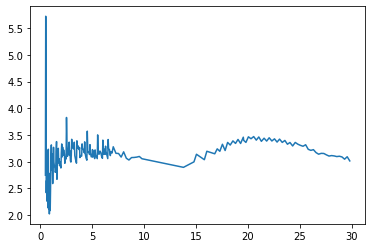

In [17]:
plt.plot(st_rates[0.5:] * 100 )